# Logistic Regression

Lets try to learn our first classification model using the selected features from **eda-notebook**


In [3]:
################# re-used (copied) from notebook 1.0-exploratory-data-analysis
################# should be handled differently, e.g. use a library
import os
import pandas as pd
import numpy as np
from PIL import Image, ExifTags

IMG_DIR = "../data/interim"

def get_exif_data(filepath):
    img = Image.open(filepath)
    img_exif = img.getexif()

    if img_exif is None:
        return
    else:
        exif_data = {
            'exposure_time': img_exif.get(0x829a),
            #'f_number': img_exif.get(0x829d),
            'shutter_speed': img_exif.get(0x9201),
            #'arperture': img_exif.get(0x9202),
            'brightness': img_exif.get(0x9203),
            #'focal_length': img_exif.get(0x920a),
            'iso_speed': img_exif.get(0x8827)
        }
        return exif_data
    
def get_exif_data_frame(path):
    exifs = np.empty(0)
    for dirpath, dirnames, filenames in os.walk(path):
        for file in filenames:
            exifs = np.append(exifs, get_exif_data(os.path.sep.join((dirpath, file))))
    return pd.DataFrame.from_dict(data = exifs.tolist())

# load data
open_exif_data = get_exif_data_frame(os.path.sep.join((IMG_DIR, "open")))
open_exif_data['label'] = 0 # set label column to '0', open

closed_exif_data = get_exif_data_frame(os.path.sep.join((IMG_DIR, "closed")))
closed_exif_data['label'] = 1 # set label column to '1', closed

all_exif_data = pd.concat([open_exif_data, closed_exif_data], ignore_index = True)

In [4]:
# train first model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

#split dataset in features and target variable
feature_cols = ['exposure_time', 'shutter_speed', 'brightness', 'iso_speed']
X = all_exif_data[feature_cols] # Features
y = all_exif_data.label # Target variable

# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train,y_train)

# predict using test data
y_pred=logreg.predict(X_test)

# evaluate model
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
display(cnf_matrix)


print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))

Confusion Matrix


array([[440,  14],
       [  0, 188]])

Accuracy: 0.9781931464174455
Precision: 0.9306930693069307
Recall: 1.0


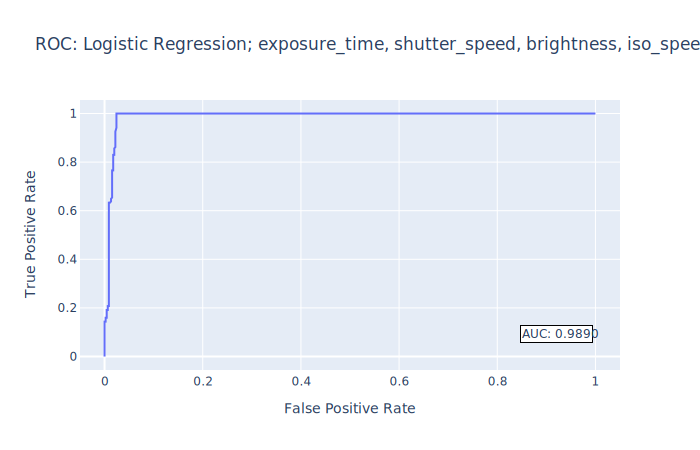

In [11]:
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import numpy as np

y_pred_proba = logreg.predict_proba(X_test)[::,1] # get values of 'closed' class (idx = 1)
fpr, tpr, thresholds = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# create data frame for convenience for plotting data
df = pd.DataFrame({'false_positive_rate': fpr, 'true_positive_rate': tpr, 'thresholds': thresholds})

fig = px.line(df, x = 'false_positive_rate', y = 'true_positive_rate', title = 'ROC: Logistic Regression; exposure_time, shutter_speed, brightness, iso_speed', hover_name = 'thresholds')
fig.update_layout(
    xaxis = {'range': [-0.05, 1.05]}, # have some padding to left and right
    xaxis_title_text = 'False Positive Rate', # xaxis label
    yaxis_title_text = 'True Positive Rate', # yaxis label
    annotations = [
        dict(
            text = 'AUC: {:.4f}'.format(auc),
            align = 'left',
            showarrow = False,
            xref = 'paper',
            yref = 'paper',
            x = 0.95,
            y = 0.1,
            bordercolor = 'black',
            borderwidth = 1,
            bgcolor = 'white'
        )
    ]
)
fig.show(renderer="svg")
